In [1]:
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools
import pandas as pd
import numpy as np
import os
import datetime
from datetime import datetime
from datetime import timedelta
from datetime import date

import scipy 
from scipy import optimize
import scipy.signal as signal 
import sys

    
sys.path.append('../../dsmuc/')
from dsmuc.custom import detect_peaks
import dsmuc.io as io
import dsmuc.preprocessing as pp
import dsmuc.features as ff
import dsmuc.custom as cs


import pytz
from azure.storage.blob import BlockBlobService
from io import StringIO
from azure.storage.blob import AppendBlobService
from azure.storage.blob import BlockBlobService
import requests
import json

label_dict = {1:'walking',
             2:'walking upstairs',
             3:'walking downstairs',
             4:'sitting',
             5:'standing',
             6:'laying',
             7:'unknown'}


download_dir =  "../../data/G9_data/Downloaded"
account_name='watchstorage'
account_key='TJWcjsCs4aK9Xorw4DIAZGvKz0AFb2kvgSh49t+3nADR2usZ1ED14GLBQ/klJsSSrKykxu0ghCXn46+0bv2J8Q=='
container_name_ = 'jnj'

# Model saved
filename = 'finalized_model.sav'
logreg = pickle.load(open(filename, 'rb'), encoding = 'iso-8859-1')


In [2]:
def time_to_str(t):
    t_woM = t.replace(microsecond=0)
    dt64 = np.datetime64(t_woM)
    a = dt64.astype('datetime64[s]')
    
    return np.datetime_as_string(a)+"Z"
def f(x):
    u, c = np.unique(x['predictions'].values, return_counts=True)
    outcome = u[np.argmax(c)]
    return outcome

In [25]:
##################
#### READ DATA ###
##################
day_now=0
day_before=1

account_name='watchstorage'
account_key='TJWcjsCs4aK9Xorw4DIAZGvKz0AFb2kvgSh49t+3nADR2usZ1ED14GLBQ/klJsSSrKykxu0ghCXn46+0bv2J8Q=='
container_name_ = 'jnj'

blob_service = BlockBlobService(account_name=account_name, account_key = account_key)


blobs = [];blob_date = []
generator = blob_service.list_blobs(container_name_)
for blob in generator:
    blobs.append(blob.name)
    blob_date.append(blob.name[:10])
blob_table = pd.DataFrame()
blob_table['date'] = blob_date
blob_table['blobname'] = blobs    
today = date.today().strftime('%Y-%m-%d')
yesterday = (date.today() - timedelta(3)).strftime('%Y-%m-%d')

blob_table[(blob_table['date']==yesterday)|(blob_table['date']==today)] 


In [26]:
blob_table

,date,blobname
0,2017-11-29,2017-11-29/861452078_35dbed8e8c614be8aebdb5b5d...
1,2017-11-29,2017-11-29/861452078_675bc4bf31d94968974e58c2a...
2,2017-11-30,2017-11-30/873240569_c3066418061948fdbc1f1fdcd...
3,2017-12-05,2017-12-05/873240569_6644c7aa2d104486b60aa0428...
4,2017-12-06,2017-12-06/873240569_34f3bf5800304afba5659dd3f...
5,2017-12-07,2017-12-07/873240569_4cd837cbf09141be8211a802d...
6,2017-12-08,2017-12-08/873240569_3a862ff4cf5c40f08c26524da...
7,2017-12-11,2017-12-11/873240569_231439354b5a46ada32e77abe...
8,2017-12-12,2017-12-12/873240569_075dc9e3d8ea4e9b8647d834e...
9,2017-12-13,2017-12-13/873240569_b4a0e0c810ae426aac376cefa...


In [30]:
yesterday

'2018-05-27'

,date,blobname


In [9]:
blob_df['id'].unique()[::-1]

NameError: name 'blob_df' is not defined

Watch  watch-sensor-356969030313395  is being processed


../../dsmuc/dsmuc/custom/__init__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['date'] = pd.to_datetime(df[unix_col],unit=unit)


Extracting interested sensor data...
READ DATA FRAMES SIZE AFTER CLEANING : 1160467
doing time: 2018-04-25 16:00:00  -  2018-04-25 16:05:00


/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:14: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:17: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
../../dsmuc/dsmuc/features/__init__.py:167: RuntimeWarning: Mean of empty slice.
  list_.append(np.diff(ind).mean())
/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


doing time: 2018-04-25 16:05:00  -  2018-04-25 16:10:00
doing time: 2018-04-25 16:10:00  -  2018-04-25 16:15:00
doing time: 2018-04-25 16:15:00  -  2018-04-25 16:20:00
doing time: 2018-04-25 16:20:00  -  2018-04-25 16:25:00
doing time: 2018-04-25 16:25:00  -  2018-04-25 16:30:00
doing time: 2018-04-25 16:30:00  -  2018-04-25 16:35:00
doing time: 2018-04-25 16:35:00  -  2018-04-25 16:40:00
doing time: 2018-04-25 16:40:00  -  2018-04-25 16:45:00
doing time: 2018-04-25 16:45:00  -  2018-04-25 16:50:00
doing time: 2018-04-25 16:50:00  -  2018-04-25 16:55:00
doing time: 2018-04-25 16:55:00  -  2018-04-25 17:00:00
doing time: 2018-04-25 17:00:00  -  2018-04-25 17:05:00
doing time: 2018-04-25 17:05:00  -  2018-04-25 17:10:00
doing time: 2018-04-25 17:10:00  -  2018-04-25 17:15:00
doing time: 2018-04-25 17:15:00  -  2018-04-25 17:20:00
doing time: 2018-04-25 17:20:00  -  2018-04-25 17:25:00
doing time: 2018-04-25 17:25:00  -  2018-04-25 17:30:00
doing time: 2018-04-25 17:30:00  -  2018-04-25 1

doing time: 2018-04-26 04:35:00  -  2018-04-26 04:40:00
doing time: 2018-04-26 04:40:00  -  2018-04-26 04:45:00
doing time: 2018-04-26 04:45:00  -  2018-04-26 04:50:00
doing time: 2018-04-26 04:50:00  -  2018-04-26 04:55:00
doing time: 2018-04-26 04:55:00  -  2018-04-26 05:00:00
doing time: 2018-04-26 05:00:00  -  2018-04-26 05:05:00
doing time: 2018-04-26 05:05:00  -  2018-04-26 05:10:00
doing time: 2018-04-26 05:10:00  -  2018-04-26 05:15:00
doing time: 2018-04-26 05:15:00  -  2018-04-26 05:20:00
doing time: 2018-04-26 05:20:00  -  2018-04-26 05:25:00
doing time: 2018-04-26 05:25:00  -  2018-04-26 05:30:00
doing time: 2018-04-26 05:30:00  -  2018-04-26 05:35:00
doing time: 2018-04-26 05:35:00  -  2018-04-26 05:40:00
doing time: 2018-04-26 05:40:00  -  2018-04-26 05:45:00
doing time: 2018-04-26 05:45:00  -  2018-04-26 05:50:00
doing time: 2018-04-26 05:50:00  -  2018-04-26 05:55:00
doing time: 2018-04-26 05:55:00  -  2018-04-26 06:00:00
doing time: 2018-04-26 06:00:00  -  2018-04-26 0

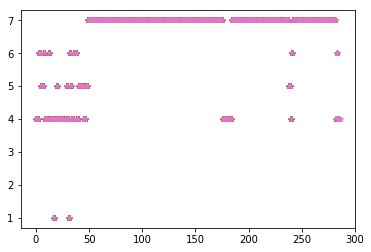

success uploading watch data


In [77]:
feature_list =  ['aoa','ate','apf','rms','std','minimax','cor','mean','min','max']
preserved_features=['start']


for watch_id in [blob_df['id'].unique()[::-1][0]]:
    print("Watch ", watch_id," is being processed" )
    df_temp = io.read_g9(blob_df[blob_df['id']==watch_id], sort=False)
    df_temp = df_temp.drop_duplicates(keep='last')[::2].sort_index()
    print("READ DATA FRAMES SIZE AFTER CLEANING :",df_temp.shape[0])


    # Time to do analysis is specified
    start = yesterday + 'T16:00:00.0000Z'
    start_temp = np.datetime64(start)
    t = pd.Timestamp(start_temp)
    end = today + 'T16:00:00.0000Z'
    end_temp = np.datetime64(end)
    end_time = pd.Timestamp(end_temp)

    # Initialize 
    whole_window_size = timedelta(minutes = 5)
    window_size = timedelta(seconds=2)
    window_slide = timedelta(seconds=1)
    samples_count = []
    a = 0
    df_out = pd.DataFrame()
    t_start_list = []
    t_end_list = []
    outcome_list = []
    while (t + whole_window_size < end_time):
        label_list = []
        increment = 0
        DF = pd.DataFrame()
        t_end5min= t + whole_window_size 
        print("doing time:",t, ' - ', t_end5min)
        t_start_list.append(time_to_str(t))
        t_end_list.append(time_to_str(t_end5min))
        if df_temp.between_time(t.to_pydatetime().time(), t_end5min.to_pydatetime().time()\
                                           ,include_start=True, include_end=False).shape[0] >= 10:


            while(t+window_slide< t_end5min):
                t_end = t + window_size
                snippet_df = df_temp.between_time(t.to_pydatetime().time(), t_end.to_pydatetime().time()
                                               ,include_start=True, include_end=False)
                if snippet_df.shape[0]>= 20:
                    increment +=1
                    ser = ff.extract_features(snippet_df, index=increment, feature_list=feature_list ,\
                                preserved_features=preserved_features)
                    DF = DF.append(ser)
                t = t_end
        else:
            t = t_end5min

        if DF.shape[0]<=11:
            outcome = 7.0
        else:
            df_X = DF.set_index(pd.DatetimeIndex(DF['start'])).drop('start' ,axis =1)
            del DF 
            df_X.fillna(df_X.mean().fillna(0), inplace=True)
            X_test = df_X.values
            y_pred = logreg.predict(X_test)                
            u, c = np.unique(y_pred, return_counts=True)
            outcome = u[np.argmax(c)]
        outcome_list.append(label_dict[int(outcome)])
        out_ser = pd.Series(outcome,name=(t-whole_window_size, t) )
        df_out = df_out.append(out_ser)
        plt.plot(list(range(df_out.shape[0])), df_out[0], "*")
        ## Send predictions 
    plt.show()   
    dict_list = []
    for i in range(len(outcome_list)):
        payload_dict = {'address':watch_id.split("-")[2],
             'starttime':t_start_list[i],
             'endtime':t_end_list[i],
             'tasklocation':'Activity',
             'taskname':outcome_list[i],
             'name':outcome_list[i],
             'value':1}
        dict_list.append(payload_dict)
    payload = json.dumps(dict_list)
    url = "https://colife-dashboard.silverline.mobi/uploadActivityLabelForSmartWatch"
    headers = {
        'content-type': "application/json",
        'cache-control': "no-cache",
        'postman-token': "87b2b04f-175f-4a9b-f2c8-bf31de2cae7d"
        }

    response = requests.request("POST", url, data=payload, headers=headers)
    print(response.text)

